Dans la these de Justine Josnard on s'interesse a : rythme, vigueur, stabilité, régularité, symétrie, synchronisation

### IMPORTER LES LIBRAIRIES

In [ ]:
!pip install lazypredict
!pip install dtw-python
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.23.1
!pip install --upgrade pandas

  Using cached pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl (10.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas>=1.1.0; python_version >= "3.0", but you have pandas 1.0.5 which is incompatible.


Found existing installation: scikit-learn 0.23.1
Uninstalling scikit-learn-0.23.1:
  Successfully uninstalled scikit-learn-0.23.1
  Using cached scikit_learn-0.23.1-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.1 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.1 which is incompatible.


  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lazypredict 0.2.9 requires pandas==1.0.5, but you have pandas 1.3.5 which is incompatible.


In [ ]:
from math import *
import pandas as pd
import numpy as np
from numpy.fft import rfft, rfftfreq
import os
from itertools import tee
from dtw import dtw
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge as KRR
from scipy.signal import find_peaks
from xgboost import XGBClassifier
from lazypredict.Supervised import LazyClassifier, LazyRegressor

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# POUR COLAB
from google.colab import drive
drive.mount('/content/gdrive')

PATH = "/content/gdrive/MyDrive/Projet_PERCY/"

!unzip /content/gdrive/MyDrive/Projet_PERCY/data

!cp /content/gdrive/MyDrive/Projet_PERCY/uutils.py /content

from uutils import *

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/MyDrive/Projet_PERCY/data.zip
replace OK2/SCA104_OK2/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### IMPORTATION DU FICHIER PICKLE DE DONNEES

On peut choisir parmis les 4 fichiers pickle :

- complete_personal_data_marche_XCR_XCS_ECG.pkl
- complete_personal_data_marche_XCS_ECG.pkl
- complete_personal_data_marche_XCS.pkl
- complete_personal_data_marche_XCR_XCS.pkl

In [ ]:
personal_data = pd.read_pickle(PATH + "complete_personal_data_marche_XCR_XCS_ECG.pkl")

In [ ]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)
    
def get_fourier_features(signal: np.ndarray, n_bins: int = 1000) -> dict:
    """The signal is assumed to be centered and scaled to unit variance."""
    Frequency = 10
    n_samples = signal.shape[0]
    fourier = abs(rfft(signal))
    freqs = rfftfreq(n=n_samples, d=1.0 / Frequency)
    res_list = list()
    freq_bins = np.linspace(0, Frequency / 2, n_bins + 1)
    for (f_min, f_max) in pairwise(freq_bins):
        keep = (f_min <= freqs) & (freqs < f_max)
        if np.sum(fourier[keep] ** 2) > 0:
            res_list.append( np.log(np.sum(fourier[keep] ** 2)))
        else: 
            res_list.append( 0 )
    return res_list
    
# dict_capteur_column_S = np.where(personal_data.columns=="dict_capteur_S")[0].item()
# for key in personal_data.iloc[0,dict_capteur_column_S].keys():
#     for ref in ["Acc_X", "Acc_Y", "Acc_Z", "FreeAcc_X", "FreeAcc_Y", "FreeAcc_Z", "Gyr_X", "Gyr_Y", "Gyr_Z"]:
#         personal_data[ key + "_freq_S_" + ref ] = personal_data.apply(lambda row: get_fourier_features( np.array(list(importfile_XSens(row["folder"] + '/' + row["dict_capteur_S"][key])[ref])) ), axis=1)

# dict_capteur_column_R = np.where(personal_data.columns=="dict_capteur_R")[0].item()
# for key in personal_data.iloc[0,dict_capteur_column_R].keys():
#     for ref in ["Acc_X", "Acc_Y", "Acc_Z", "FreeAcc_X", "FreeAcc_Y", "FreeAcc_Z", "Gyr_X", "Gyr_Y", "Gyr_Z"]:
#         personal_data[ key + "_freq_R_" + ref ] = personal_data.apply(lambda row: get_fourier_features( np.array(list(importfile_XSens(row["folder"] + '/' + row["dict_capteur_R"][key])[ref])) ), axis=1)

In [ ]:
personal_data.to_pickle(PATH + "complete_personal_data_marche_XCR_XCS_ECG_clean.pkl")

In [ ]:
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
# Setting standard filter requirements.
order = 6
fs = 30.0
cutoff = 3.667

# on cree une colonne avec les moyenne / variance des signaux de l acceleration, free_acceleration, gyration
dict_capteur_column_S = np.where(personal_data.columns=="dict_capteur_S")[0].item()
for key in personal_data.iloc[0,dict_capteur_column_S].keys():
    for ref in ["Acc_X", "Acc_Y", "Acc_Z", "FreeAcc_X", "FreeAcc_Y", "FreeAcc_Z", "Gyr_X", "Gyr_Y", "Gyr_Z"]:
        personal_data[key + "clean_S_" + ref] = personal_data.apply(lambda row: butter_lowpass_filter(importfile_XSens(row["folder" ] + '/' + row["dict_capteur_S"][key])[ref], cutoff, fs, order), axis=1)
        personal_data[ key + "_clean_mean_S_" + ref ] = personal_data.apply(lambda row: np.mean(row[key + "clean_S_" + ref]), axis=1)
        personal_data[ key + "_clean_std_S_" + ref ] = personal_data.apply(lambda row: np.std(row[key + "clean_S_" + ref]), axis=1)

dict_capteur_column_R = np.where(personal_data.columns=="dict_capteur_R")[0].item()
for key in personal_data.iloc[0,dict_capteur_column_R].keys():
    for ref in ["Acc_X", "Acc_Y", "Acc_Z", "FreeAcc_X", "FreeAcc_Y", "FreeAcc_Z", "Gyr_X", "Gyr_Y", "Gyr_Z"]:
        personal_data[key + "clean_R_" + ref] = personal_data.apply(lambda row: butter_lowpass_filter(importfile_XSens(row["folder" ] + '/' + row["dict_capteur_R"][key])[ref], cutoff, fs, order), axis=1)
        personal_data[ key + "_clean_mean_R_" + ref ] = personal_data.apply(lambda row: np.mean(row[key + "clean_R_" + ref]), axis=1)
        personal_data[ key + "_clean_std_R_" + ref ] = personal_data.apply(lambda row: np.std(row[key + "clean_R_" + ref]), axis=1)

In [ ]:
# dict_capteur_column_S = np.where(personal_data.columns=="dict_capteur_S")[0].item()
# for key in personal_data.iloc[0,dict_capteur_column_S].keys():
#     for ref in ["Acc_X", "Acc_Y", "Acc_Z", "FreeAcc_X", "FreeAcc_Y", "FreeAcc_Z", "Gyr_X", "Gyr_Y", "Gyr_Z"]:
#         personal_data[ key + "_freq_mean_S_" + ref ] = personal_data.apply(lambda row: np.mean(row[ key + "_freq_S_" + ref ]), axis=1)
#         personal_data[ key + "_freq_std_S_" + ref ] = personal_data.apply(lambda row: np.std(row[ key + "_freq_S_" + ref ]), axis=1)
#         #personal_data[ key + "_freq_min_S_" + ref ] = personal_data.apply(lambda row: np.min(row[ key + "_freq_S_" + ref ]), axis=1)
#         #personal_data[ key + "_freq_max_S_" + ref ] = personal_data.apply(lambda row: np.max(row[ key + "_freq_S_" + ref ]), axis=1)

# dict_capteur_column_R = np.where(personal_data.columns=="dict_capteur_R")[0].item()
# for key in personal_data.iloc[0,dict_capteur_column_R].keys():
#     for ref in ["Acc_X", "Acc_Y", "Acc_Z", "FreeAcc_X", "FreeAcc_Y", "FreeAcc_Z", "Gyr_X", "Gyr_Y", "Gyr_Z"]:
#         personal_data[ key + "_freq_mean_R_" + ref ] = personal_data.apply(lambda row: np.mean(row[ key + "_freq_R_" + ref ]), axis=1)
#         personal_data[ key + "_freq_std_R_" + ref ] = personal_data.apply(lambda row: np.std(row[ key + "_freq_R_" + ref ]), axis=1)
#         #personal_data[ key + "_freq_min_R_" + ref ] = personal_data.apply(lambda row: np.min(row[ key + "_freq_R_" + ref ]), axis=1)
#         #personal_data[ key + "_freq_max_R_" + ref ] = personal_data.apply(lambda row: np.max(row[ key + "_freq_R_" + ref ]), axis=1)

In [ ]:
# dict_capteur_column_S = np.where(personal_data.columns=="dict_capteur_S")[0].item()
# for key in personal_data.iloc[0,dict_capteur_column_S].keys():
#     for ref in ["Acc_X", "Acc_Y", "Acc_Z", "FreeAcc_X", "FreeAcc_Y", "FreeAcc_Z", "Gyr_X", "Gyr_Y", "Gyr_Z"]:
#         personal_data
#         personal_data[ key + "_freq_mean_S_" + ref ] = personal_data.apply(lambda row: np.mean(row[ key + "_freq_S_" + ref ]), axis=1)

# dict_capteur_column_R = np.where(personal_data.columns=="dict_capteur_R")[0].item()
# for key in personal_data.iloc[0,dict_capteur_column_R].keys():
#     for ref in ["Acc_X", "Acc_Y", "Acc_Z", "FreeAcc_X", "FreeAcc_Y", "FreeAcc_Z", "Gyr_X", "Gyr_Y", "Gyr_Z"]:
#         personal_data[ key + "_freq_mean_R_" + ref ] = personal_data.apply(lambda row: np.mean(row[ key + "_freq_R_" + ref ]), axis=1)
#         personal_data[ key + "_freq_std_R_" + ref ] = personal_data.apply(lambda row: np.std(row[ key + "_freq_R_" + ref ]), axis=1)
#         #personal_data[ key + "_freq_min_R_" + ref ] = personal_data.apply(lambda row: np.min(row[ key + "_freq_R_" + ref ]), axis=1)
#         #personal_data[ key + "_freq_max_R_" + ref ] = personal_data.apply(lambda row: np.max(row[ key + "_freq_R_" + ref ]), axis=1)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
personal_data

Numéro inclusion Sexe  age  taille       ( cm )  poids      ( Kg )  \
id                                                                       
6                6PC    0   44                  180              70.00   
9                9RA    1   23                  171              82.00   
10              10BR    1   30                  178              72.00   
11              11BL    1   39                  187             100.00   
12              12GM    1   35                  176              98.00   
14              14PS    1   41                  181              87.00   
16              16MM    1   31                  180              81.00   
18              18GY    1   35                  182              74.00   
22              22SJ    1   20                  182              80.00   
23              23BT    1   23                  182              57.00   
24              24DH    1   26                  182              80.00   
25              25LE    0   35                  186              70.00   
30              30BM    1   30                  173              73.00   
31              31MC    0   38                  168              58.00   
33              33PR    1   33                  177              82.00   
34              34BA    1   45                  180              83.00   
35              35AF    1   32                  182              92.00   
36              36HE    0   29                  166              64.00   
37              37GA    0   25                  159              68.00   
38              38DM    0   29                  166              52.00   
39              39CE    0   33                  157              64.00   
40              40RM    0   27                  165              61.00   
41              41LL    0   25                  173              63.00   
42              42DJ    0   34                  160              50.00   
43              43AD    1   32                  173              70.00   
44              44MG    1   27                  185             103.00   
45              45BF    1   24                  183              86.00   
48              48LO    1   36                  180              75.00   
49              49HC    1   27                  178              67.00   
50              50CT    1   19                  178              66.00   
51              51FM    1   40                  185              70.00   
52              52SQ    1   22                  168              65.00   
53              53PD    1   43                  192             100.00   
54              54PJ    0   30                  164              83.00   
55              55OM    0   26                  160              85.00   
56              56HL    0   25                  178              77.00   
57              57RJ    1   23                  165              63.00   
58              58PT    1   22                  195              95.00   
59              59GF    1   30                  175              81.00   
60              60DJ    1   33                  173              80.00   
61              61CA    1   38                  174              95.00   
62              62GM    1   27                  182              83.00   
64              64BJ    1   32                  180              85.00   
66              66CH    1   21                  180              71.00   
67              67AB    0   38                  179              97.00   
68              68BW    0   24                  162              62.00   
69              69BC    0   42                  157              53.00   
70              70CB    1   36                  194             100.00   
71              71DA    0   22                  167              55.00   
76              76AF    1   30                  175              63.00   
77              77BS    1   43                  176              80.00   
78              78GP    1   53                  183              86.00   
83      

### TESTER DES MODELES DE PREDICTIONS SUR LES DONNEES DE LA MARCHE

In [ ]:
filter_col_steps = [col for col in personal_data if "steps_" in col and col not in ["steps_folder_S","steps_folder_R","steps_x_coord_S","steps_x_coord_R"]]
filter_col_pieds = [col for col in personal_data if "pied" in col and "_clean_" in col and "freq_S" not in col and "freq_R" not in col]
filter_col_tete = [col for col in personal_data if "tete" in col and "_clean_" in col and  "freq_S" not in col and "freq_R" not in col]
filter_col_tronc = [col for col in personal_data if "tronc" in col and "_clean_" in col and  "freq_S" not in col and "freq_R" not in col]

columns_of_interest = filter_col_steps + filter_col_pieds + filter_col_tete + filter_col_tronc
columns_of_interest

['steps_right_S_mean',
 'steps_right_S_std',
 'steps_left_S_mean',
 'steps_left_S_std',
 'steps_diff_S',
 'steps_right_R_mean',
 'steps_right_R_std',
 'steps_left_R_mean',
 'steps_left_R_std',
 'steps_diff_R',
 'steps_right_diffSR_mean',
 'steps_right_diffSR_std',
 'steps_left_diffSR_mean',
 'steps_left_diffSR_std',
 'steps_diff_SR',
 'nom_pied_gauche_clean_mean_S_Acc_X',
 'nom_pied_gauche_clean_std_S_Acc_X',
 'nom_pied_gauche_clean_mean_S_Acc_Y',
 'nom_pied_gauche_clean_std_S_Acc_Y',
 'nom_pied_gauche_clean_mean_S_Acc_Z',
 'nom_pied_gauche_clean_std_S_Acc_Z',
 'nom_pied_gauche_clean_mean_S_FreeAcc_X',
 'nom_pied_gauche_clean_std_S_FreeAcc_X',
 'nom_pied_gauche_clean_mean_S_FreeAcc_Y',
 'nom_pied_gauche_clean_std_S_FreeAcc_Y',
 'nom_pied_gauche_clean_mean_S_FreeAcc_Z',
 'nom_pied_gauche_clean_std_S_FreeAcc_Z',
 'nom_pied_gauche_clean_mean_S_Gyr_X',
 'nom_pied_gauche_clean_std_S_Gyr_X',
 'nom_pied_gauche_clean_mean_S_Gyr_Y',
 'nom_pied_gauche_clean_std_S_Gyr_Y',
 'nom_pied_gauche_clean_

In [ ]:
personal_data[['nom_troncclean_S_Gyr_Y']]

nom_troncclean_S_Gyr_Y
id                                                    
6    [0.00021087640911078884, 0.0021217194657177263...
9    [-2.0605283543240983e-05, -0.00020383085770754...
10   [-2.8135475479832977e-05, -0.00027831338285744...
11   [1.9633797559664176e-05, 0.0002002360694256380...
12   [1.5919015725077142e-05, 0.0001593100287341181...
14   [3.424182445501617e-06, 3.555053307847353e-05,...
16   [-5.945249702204771e-05, -0.000596342000993757...
18   [1.501148041612107e-05, 0.00015720872848684207...
22   [1.2724303347332294e-06, 2.613311234100192e-06...
23   [-3.367567289440316e-05, -0.000328269824283612...
24   [-3.393241604398348e-05, -0.000311844154435780...
25   [1.2131819155993095e-07, 3.6591028492074116e-0...
30   [9.251217444767758e-06, 0.00010729130386182794...
31   [1.3431522572549875e-05, 0.0001318490173593931...
33   [-2.6575267109306423e-05, -0.00026450047711632...
34   [-1.4387020887471502e-05, -0.00014254443361616...
35   [3.348099951724885e-05, 0.0003350595993785376,...
36   [2.693922168398622e-05, 0.0002662510199477076,...
37   [1.913065622257454e-05, 0.00019173717957864277...
38   [-3.670580633010934e-06, -3.5367869826979726e-...
39   [3.0916389374737755e-05, 0.0003156848837887018...
40   [-0.00017743302763743453, -0.00176550516847954...
41   [1.5636880395867998e-05, 0.0001542038703909143...
42   [4.255447170461485e-05, 0.00042338624509487803...
43   [1.793346197563041e-05, 0.00017153422971945956...
44   [1.644472788850351e-05, 0.00015879006612228767...
45   [3.3244946291810537e-06, 3.5005295126864564e-0...
48   [4.932666005673161e-05, 0.0004946870263848876,...
49   [2.439718236781185e-05, 0.00024140577388939965...
50   [2.9532985810515594e-05, 0.0002854107415558041...
51   [3.0577826979686786e-05, 0.0003119125714148756...
52   [2.7111324234803796e-05, 0.000274974852590003,...
53   [-2.3563002244450158e-05, -0.00024480188450489...
54   [6.943726632275924e-05, 0.0006793292668776968,...
55   [4.868433195723214e-05, 0.00048353639450239995...
56   [-3.462176669835115e-05, -0.000338948830365066...
57   [3.575689117286926e-05, 0.00034031645845556573...
58   [1.4448150208800149e-05, 0.0001536059443633735...
59   [-1.2470381551044065e-06, -8.32258952930389e-0...
60   [-2.395328944985613e-06, -2.1714476408927003e-...
61   [1.0239631548097118e-05, 0.0001073018530725742...
62   [1.3818988424663764e-05, 0.000137080285517682,...
64   [2.294888767787159e-05, 0.00022311006334094417...
66   [4.956177283107257e-06, 4.9123296720876734e-05...
67   [2.54222740639384e-05, 0.000256885570074473, 0...
68   [-0.00012196804326820935, -0.00122765592105391...
69   [6.645509589301861e-05, 0.0006628869275355639,...
70   [3.817573139528897e-05, 0.00038138929606818873...
71   [-1.4182942999343557e-05, -0.00015463040678477...
76   [8.185686351454567e-06, 9.258274170013793e-05,...
77   [-1.6168235265878548e-05, -0.00016328804788936...
78   [7.82831493445632e-06, 8.257909579295114e-05, ...
83   [-9.199022408864067e-05, -0.000867644601558724...
84   [-5.603771908751973e-05, -0.000545133379650839...
85   [7.873174451800573e-05, 0.0007938244887737852,...
86   [4.2150077732748415e-05, 0.0004309706839794702...
88   [-7.043038268157542e-06, -6.313384628812284e-0...
89   [4.013281012890305e-05, 0.0004090841616678143,...
90   [7.0082415775550815e-06, 7.774030990882278e-05...
91   [-2.5148602794605532e-05, -0.00025976516225498...
92   [0.0001878090245946494, 0.001834250891102421, ...
94   [5.658694252838019e-06, 5.8216104291681824e-05...
95   [-1.411711142252809e-05, -0.000139435402211325...
96   [6.141427801114861e-05, 0.0006262584233386878,...
98   [4.2783941772371615e-05, 0.0004319292670638301...
100  [9.338679396822591e-06, 8.910878985296991e-05,...
101  [0.00012209030191086663, 0.0012367320644746061...
102  [-3.85726017583765e-05, -0.0003574698240681544...
103  [6.631120687512195e-06, 7.18305008155663e-05, ...
104  [0.00023631184949009034, 0.002328070487584683,...
105  [1.4525267198783982e-05, 0.0001511548315538882...
107  [2.967405347

In [ ]:
XXX = personal_data[['nom_troncclean_S_Gyr_Y']]
y = personal_data[["surrentrainement"]]
X_train, X_test, y_train, y_test = train_test_split(XXX, y, test_size=0.33)

import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def DTW(a, b):
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)

knn = KNeighborsClassifier(n_neighbors=3,metric =DTW)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

ValueError: ignored

In [ ]:
best_models = []
best_models_accuracy = []

for _ in range(50):

    X = personal_data[columns_of_interest]                  
    y = personal_data[["surrentrainement"]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)

    best_models += list( models.head().index )
    best_models_accuracy += list( models.head()["F1 Score"] )

100%|██████████| 29/29 [00:02<00:00, 10.74it/s]


In [ ]:
models.head()

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                  
NuSVC                     0.60               0.53     0.53      0.55   
XGBClassifier             0.60               0.53     0.53      0.55   
Perceptron                0.56               0.53     0.53      0.56   
ExtraTreesClassifier      0.60               0.52     0.52      0.51   
SGDClassifier             0.56               0.52     0.52      0.54   

                      Time Taken  
Model                             
NuSVC                       0.05  
XGBClassifier               0.91  
Perceptron                  0.05  
ExtraTreesClassifier        0.15  
SGDClassifier               0.04

In [ ]:
best_sum_accuracy = {}
for model in np.unique(best_models):
    idx_best = [i for i, x in enumerate(best_models) if x == model]
    best_sum_accuracy[model] = np.array(best_models_accuracy)[idx_best].sum()

print( max(best_sum_accuracy, key=best_sum_accuracy.get) )

best_sum_accuracy

LinearDiscriminantAnalysis


{'AdaBoostClassifier': 3.1990671344423967,
 'BaggingClassifier': 4.780283824923076,
 'BernoulliNB': 3.578828054438955,
 'CalibratedClassifierCV': 4.704017564509674,
 'DecisionTreeClassifier': 5.897579278247239,
 'DummyClassifier': 7.972849356442686,
 'ExtraTreeClassifier': 7.2312962384560775,
 'ExtraTreesClassifier': 4.515014171206121,
 'GaussianNB': 7.516443799346516,
 'KNeighborsClassifier': 11.107764534905058,
 'LGBMClassifier': 3.982420056460184,
 'LabelPropagation': 1.5043541748476517,
 'LabelSpreading': 1.7732430637365406,
 'LinearDiscriminantAnalysis': 11.196201197264605,
 'LinearSVC': 6.262163991846177,
 'LogisticRegression': 6.924105763517529,
 'NearestCentroid': 7.934774158911521,
 'NuSVC': 7.592220082217884,
 'PassiveAggressiveClassifier': 6.39128433995574,
 'Perceptron': 3.6560384833050366,
 'QuadraticDiscriminantAnalysis': 9.033414347513718,
 'RandomForestClassifier': 2.4045964688905865,
 'RidgeClassifier': 3.1272441637173096,
 'RidgeClassifierCV': 2.6290006506692816,
 'SG

Les meilleurs modeles semblent etre les suivants (pas de "finetunning" necessaire):

- 'LinearDiscriminantAnalysis'
- 'NearestCentroid'

### ENTRAINER LES MEILLEURS MODELES DE PREDICTIONS SUR LES DONNEES DE LA MARCHE

In [ ]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
print(f"Resultats avec modele LDA:\naccuracy:{clf.score(X_test, y_test)}\nf1score:{f1_score(clf.predict(X_test), y_test)}")
                                   
def dtw1(x1, x2) :
  return dtw(x1,x2).distance

clf = NearestCentroid(metric=dtw1)
clf.fit(X_train, y_train)
print(f"Resultats avec modele NearestCentroid:\naccuracy:{clf.score(X_test, y_test)}\nf1score:{f1_score(clf.predict(X_test), y_test)}")

Resultats avec modele LDA:
accuracy:0.56
f1score:0.26666666666666666
Resultats avec modele NearestCentroid:
accuracy:0.52
f1score:0.4000000000000001


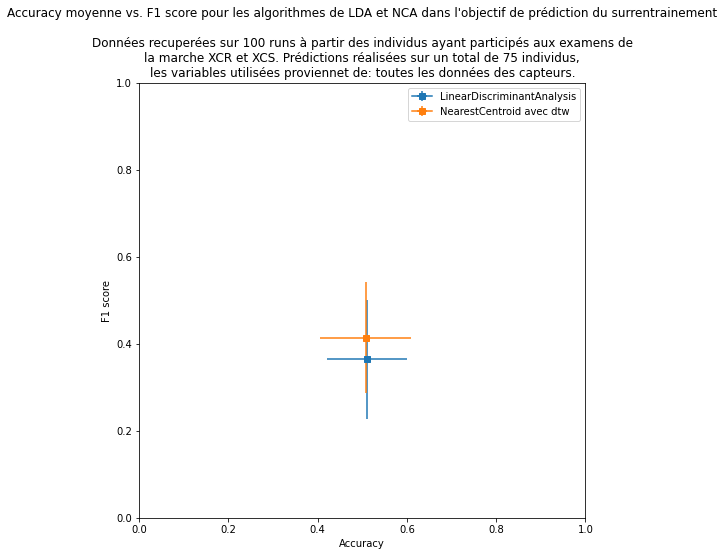

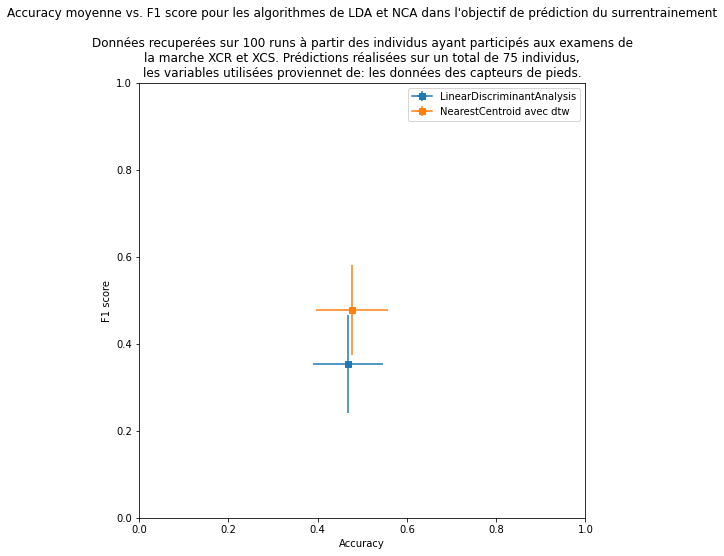

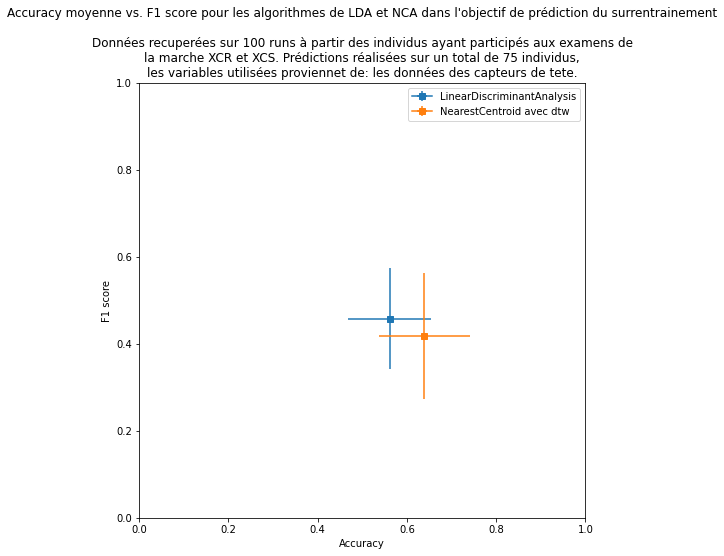

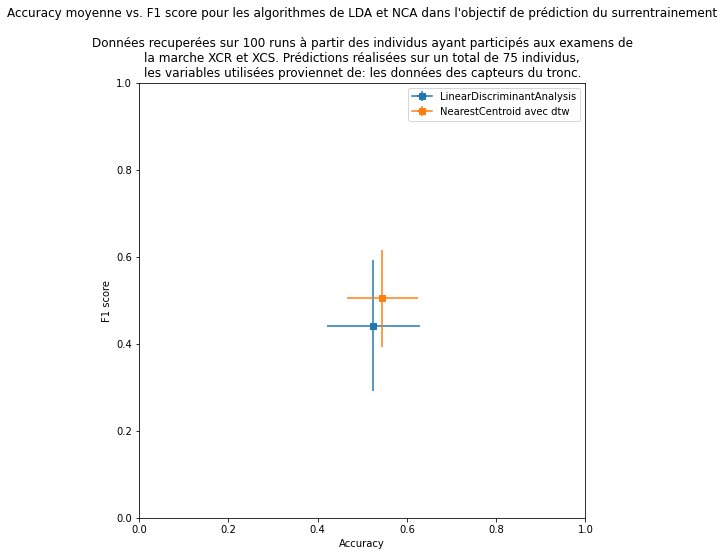

In [ ]:
columns_of_interest = filter_col_steps + filter_col_pieds + filter_col_tete + filter_col_tronc
data_features = [columns_of_interest, filter_col_steps + filter_col_pieds, filter_col_steps + filter_col_tete, filter_col_steps + filter_col_tronc]
data_features_label = ["toutes les données des capteurs", "les données des capteurs de pieds", "les données des capteurs de tete", "les données des capteurs du tronc"]
#data_features = [filter_col_steps + filter_col_tronc]
#data_features_label = ["les données des capteurs du tronc"]

for i in range(len(data_features)):

    def dtw1(x1, x2) :
        return dtw(x1,x2).distance
        
    X = personal_data[data_features[i]]                  
    y = personal_data[["surrentrainement"]]

    err_plot_LDA_accuracy = []
    err_plot_LDA_F1score = []

    err_plot_NC_accuracy = []
    err_plot_NC_F1score = []

    for _ in range(100):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

        clf = LinearDiscriminantAnalysis()
        clf.fit(X_train, y_train)
        err_plot_LDA_accuracy.append( clf.score(X_test, y_test) )
        err_plot_LDA_F1score.append( f1_score(clf.predict(X_test), y_test) )
                                          
        clf = NearestCentroid(metric=dtw1)
        clf.fit(X_train, y_train)
        err_plot_NC_accuracy.append( clf.score(X_test, y_test) )
        err_plot_NC_F1score.append( f1_score(clf.predict(X_test), y_test) )

    plt.figure(figsize=(8,8))

    plt.errorbar(np.mean(err_plot_LDA_accuracy), np.mean(err_plot_LDA_F1score), marker='s', xerr = np.std(err_plot_LDA_accuracy), yerr = np.std(err_plot_LDA_F1score), label='LinearDiscriminantAnalysis')

    plt.errorbar(np.mean(err_plot_NC_accuracy), np.mean(err_plot_NC_F1score), marker='s', xerr = np.std(err_plot_NC_accuracy), yerr = np.std(err_plot_NC_F1score), label='NearestCentroid avec dtw')

    plt.title(f"Accuracy moyenne vs. F1 score pour les algorithmes de LDA et NCA dans l'objectif de prédiction du surrentrainement\n\nDonnées recuperées sur 100 runs à partir des individus ayant participés aux examens de\nla marche XCR et XCS. Prédictions réalisées sur un total de {X.shape[0]} individus,\nles variables utilisées proviennet de: {data_features_label[i]}.")

    plt.xlabel("Accuracy")
    plt.ylabel("F1 score")
    plt.legend()

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.plot();

### TESTER DES MODELES DE PREDICTIONS SUR LES DONNEES ECG

In [ ]:
def compute_mean_freq(data):
  power_spectrum = np.abs(np.fft.rfft(data))**2
  # First get the frequency vector
  freq = np.fft.rfftfreq(len(data))
  # Then calculate (weighted) mean
  return np.sum(freq * power_spectrum / np.sum(power_spectrum))

In [ ]:
# matricule 105MM nana values :
personal_data = personal_data[personal_data["Numéro inclusion"] != "105MM"]

personal_data["ecg_acf_mean"] = personal_data.apply(lambda row: np.nanmean(row['ecg_acf']), axis=1)
personal_data["ecg_acf_min"] = personal_data.apply(lambda row: np.nanmin(row['ecg_acf']), axis=1)
personal_data["ecg_acf_maxmin"] = personal_data.apply(lambda row: row['ecg_acf'][0]-row['ecg_acf'][-1], axis=1)
personal_data["ecg_peaks"] = personal_data.apply(lambda row: find_peaks(row['ecg_data'])[0], axis=1)
personal_data["ecg_peaks_nbr"] = personal_data.apply(lambda row: len(row['ecg_peaks']), axis=1)
#personal_data["ecg_mean_frequency"] = personal_data.apply(lambda row: compute_mean_freq(row['ecg_data']), axis=1)

In [ ]:
columns_of_interest = ['ecg_mean', 'ecg_std', 'ecg_min', 'ecg_max', 'ecg_acf_mean', 'ecg_acf_min', 'ecg_peaks_nbr']

best_models = []
best_models_accuracy = []

for _ in range(50):

    X = personal_data[columns_of_interest]                  
    y = personal_data[["surrentrainement"]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)

    best_models += list( models.head().index )
    best_models_accuracy += list( models.head()["Accuracy"] )

100%|██████████| 29/29 [00:00<00:00, 29.68it/s]


In [ ]:
best_sum_accuracy = {}
for model in np.unique(best_models):
    idx_best = [i for i, x in enumerate(best_models) if x == model]
    best_sum_accuracy[model] = np.array(best_models_accuracy)[idx_best].sum()

print( max(best_sum_accuracy, key=best_sum_accuracy.get) )

best_sum_accuracy

BaggingClassifier


{'AdaBoostClassifier': 6.84,
 'BaggingClassifier': 11.8,
 'BernoulliNB': 0.6,
 'CalibratedClassifierCV': 1.4,
 'DecisionTreeClassifier': 8.72,
 'DummyClassifier': 8.44,
 'ExtraTreeClassifier': 9.280000000000001,
 'ExtraTreesClassifier': 10.72,
 'GaussianNB': 1.96,
 'KNeighborsClassifier': 3.4800000000000004,
 'LGBMClassifier': 2.44,
 'LabelPropagation': 1.7600000000000002,
 'LabelSpreading': 2.4800000000000004,
 'LinearDiscriminantAnalysis': 11.0,
 'LinearSVC': 9.639999999999999,
 'LogisticRegression': 3.24,
 'NearestCentroid': 3.12,
 'NuSVC': 1.8000000000000003,
 'PassiveAggressiveClassifier': 5.160000000000001,
 'Perceptron': 7.92,
 'QuadraticDiscriminantAnalysis': 4.12,
 'RandomForestClassifier': 6.96,
 'RidgeClassifier': 9.04,
 'RidgeClassifierCV': 5.28,
 'SGDClassifier': 8.36,
 'SVC': 5.0,
 'XGBClassifier': 6.96}

Les meilleurs modeles semblent etre les suivants:

- 'LinearDiscriminantAnalysis'
- 'DecisionTreeClassifier'

### ENTRAINER LES MEILLEURS MODELES DE PREDICTIONS SUR LES DONNEES ECG

In [ ]:
X = personal_data[columns_of_interest]                
y = personal_data[["surrentrainement"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
print(f"Resultats avec modele LDA:\naccuracy:{clf.score(X_test, y_test)}\nf1score:{f1_score(clf.predict(X_test), y_test)}")

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(f"Resultats avec modele DecisionTreeClassifier:\naccuracy:{clf.score(X_test, y_test)}\nf1score:{f1_score(clf.predict(X_test), y_test)}")

ValueError: ignored

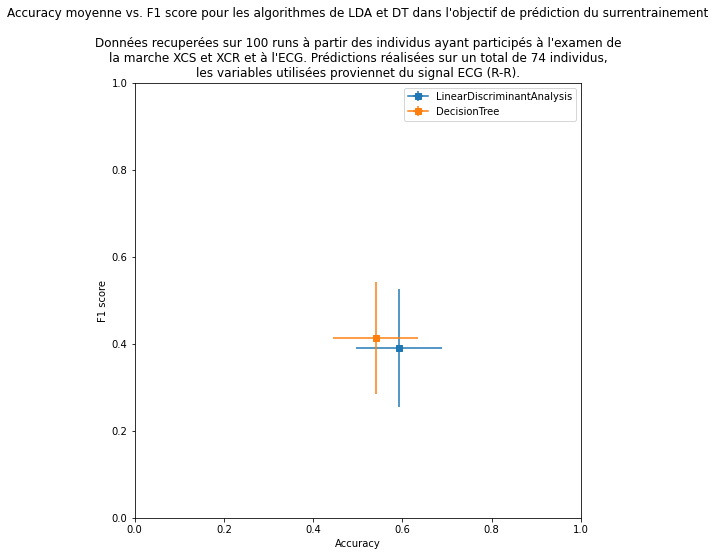

In [ ]:
columns_of_interest = ['ecg_mean', 'ecg_std', 'ecg_min', 'ecg_max', 'ecg_acf_mean', 'ecg_acf_min', 'ecg_peaks_nbr']


X = personal_data[columns_of_interest]                  
y = personal_data[["surrentrainement"]]

err_plot_LDA_accuracy = []
err_plot_LDA_F1score = []

err_plot_DTree_accuracy = []
err_plot_DTree_F1score = []

for _ in range(100):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    err_plot_LDA_accuracy.append( clf.score(X_test, y_test) )
    err_plot_LDA_F1score.append( f1_score(clf.predict(X_test), y_test) )
                                      
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    err_plot_DTree_accuracy.append( clf.score(X_test, y_test) )
    err_plot_DTree_F1score.append( f1_score(clf.predict(X_test), y_test) )

plt.figure(figsize=(8,8))

plt.errorbar(np.mean(err_plot_LDA_accuracy), np.mean(err_plot_LDA_F1score), marker='s', xerr = np.std(err_plot_LDA_accuracy), yerr = np.std(err_plot_LDA_F1score), label='LinearDiscriminantAnalysis')

plt.errorbar(np.mean(err_plot_DTree_accuracy), np.mean(err_plot_DTree_F1score), marker='s', xerr = np.std(err_plot_DTree_accuracy), yerr = np.std(err_plot_DTree_F1score), label='DecisionTree')

plt.title(f"Accuracy moyenne vs. F1 score pour les algorithmes de LDA et DT dans l'objectif de prédiction du surrentrainement\n\nDonnées recuperées sur 100 runs à partir des individus ayant participés à l'examen de\nla marche XCS et XCR et à l'ECG. Prédictions réalisées sur un total de {X.shape[0]} individus,\nles variables utilisées proviennet du signal ECG (R-R).")

plt.xlabel("Accuracy")
plt.ylabel("F1 score")
plt.legend()

plt.xlim(0,1)
plt.ylim(0,1)

plt.plot();

### COMPARAISON DES TRUE_POSITIVE, TRUE_NEGATIVE, FALSE_POSITIVE, FALSE_NEGATIVE

In [ ]:
columns_of_interest = ['ecg_mean', 'ecg_std', 'ecg_min', 'ecg_max', 'ecg_acf_mean', 'ecg_acf_min', 'ecg_peaks_nbr'] + filter_col_steps + filter_col_tronc

X = personal_data[columns_of_interest]                
y = personal_data[["surrentrainement"]]


In [ ]:
X_train.iloc[:, :7].head()

ecg_mean  ecg_std  ecg_min  ecg_max  ecg_acf_mean  ecg_acf_min  \
id                                                                   
44     72.87     8.90    57.53   115.49          0.99         0.98   
24     80.75     9.72    49.71   132.41          0.99         0.98   
12     88.03     7.66    45.71   108.94          0.99         0.98   
34     65.80     8.94    52.24   153.60          0.98         0.97   
76     69.64    12.35    51.03   103.78          0.99         0.99   

    ecg_peaks_nbr  
id                 
44            128  
24            155  
12            151  
34            125  
76            109

In [ ]:
X_train.iloc[:, 7:].head()

Empty DataFrame
Columns: []
Index: [44, 24, 12, 34, 76]

In [ ]:
# true_negative_idx_ecg = []
# true_positive_idx_ecg = []
# false_negative_idx_ecg = []
# false_positive_idx_ecg = []

# true_negative_idx_marche = []
# true_positive_idx_marche = []
# false_negative_idx_marche = []
# false_positive_idx_marche = []

TN_iou = []
TP_iou = []
FN_iou = []
FP_iou = []

for _ in range(100):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
  
    # ECG:

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train.iloc[:, :7], y_train)
    #print(f"Resultats avec modele LDA:\naccuracy:{clf.score(X_test.iloc[:, :8], y_test)}\nf1score:{f1_score(clf.predict(X_test.iloc[:, :8]), y_test)}")

    y_true = np.array(y_test["surrentrainement"])
    y_pred_ECG = clf.predict(X_test.iloc[:, :7])
    #tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()


    #true_negative_idx_ecg.append( ( (y_pred == 0) & (y_true == 0) ) ) # le non surentrainement (y_true == 0) est bien predit
    #true_positive_idx_ecg.append( ( (y_pred == 1) & (y_true == 1) ) ) # le surentrainement (y_true == 1) est bien predit

    #false_negative_idx_ecg.append( ( (y_pred == 0) & (y_true == 1) ) )
    #false_positive_idx_ecg.append( ( (y_pred == 1) & (y_true == 0) ) )

    # MARCHE

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train.iloc[:, 7:], y_train)
    #print(f"Resultats avec modele LDA:\naccuracy:{clf.score(X_test.iloc[:, 8:], y_test)}\nf1score:{f1_score(clf.predict(X_test.iloc[:, 8:]), y_test)}")

    y_true = np.array(y_test["surrentrainement"])
    y_pred_MARCHE = clf.predict(X_test.iloc[:, 7:])
    #tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    #print(tn, fp, fn, tp)

    #true_negative_idx_marche.append( ( (y_pred == 0) & (y_true == 0) ) ) # le non surentrainement (y_true == 0) est bien predit
    #true_positive_idx_marche.append( ( (y_pred == 1) & (y_true == 1) ) ) # le surentrainement (y_true == 1) est bien predit

    #false_negative_idx_marche.append( ( (y_pred == 0) & (y_true == 1) ) )
    #false_positive_idx_marche.append( ( (y_pred == 1) & (y_true == 0) ) )

    # resultats
    TN_ECG = ( (y_pred_ECG==0) & (y_true==0) )
    TN_MARCHE = ( (y_pred_MARCHE==0) & (y_true==0) )
    TN_iou.append( (TN_ECG & TN_MARCHE).sum() / (TN_ECG | TN_MARCHE).sum() )

    TP_ECG = ( (y_pred_ECG==1) & (y_true==1) )
    TP_MARCHE = ( (y_pred_MARCHE==1) & (y_true==1) )
    TP_iou.append( (TP_ECG & TP_MARCHE).sum() / (TP_ECG | TP_MARCHE).sum() )

    FN_ECG = ( (y_pred_ECG==0) & (y_true==1) )
    FN_MARCHE = ( (y_pred_MARCHE==0) & (y_true==1) )
    FN_iou.append( (FN_ECG & FN_MARCHE).sum() / (FN_ECG | FN_MARCHE).sum() )

    FP_ECG = ( (y_pred_ECG==1) & (y_true==0) )
    FP_MARCHE = ( (y_pred_MARCHE==1) & (y_true==0) )
    FP_iou.append( (FP_ECG & FP_MARCHE).sum() / (FP_ECG | FP_MARCHE).sum() )

[18, 15, 17, 14, 22, 17, 15, 18, 19, 20]
[18, 24, 19, 22, 21, 18, 22, 19, 18, 20]
[18, 24, 19, 22, 21, 18, 22, 19, 18, 20]
[18, 15, 17, 14, 22, 17, 15, 18, 19, 20]


In [ ]:
TN[:10]

[18, 15, 17, 14, 22, 17, 15, 18, 19, 20]

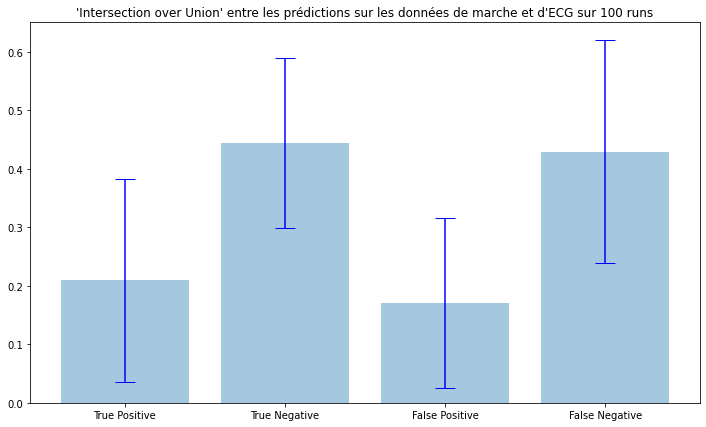

In [ ]:
materials = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
x_pos = materials
plt.figure(figsize=(12,7))
plt.bar(x_pos, [np.mean(TP_iou), np.mean(TN_iou), np.mean(FP_iou), np.mean(FN_iou)], yerr=[np.std(TP_iou), np.std(TN_iou), np.std(FP_iou), np.std(FN_iou)], ecolor="blue", align='center', alpha=0.4,capsize=10)
plt.title("'Intersection over Union' entre les prédictions sur les données de marche et d'ECG sur 100 runs")
plt.show();

In [ ]:
#print(list(true_negative_idx_ecg))
#print(list(true_negative_idx_marche))
print(f"Proportion de memes true negative entre les prediction ECG et MARCHE: {(true_negative_idx_ecg==true_negative_idx_marche).sum()/len(true_negative_idx_ecg)}")

#print(list(true_positive_idx_ecg))
#print(list(true_positive_idx_marche))
print(f"Proportion de memes true positive entre les prediction ECG et MARCHE: {(true_positive_idx_ecg==true_positive_idx_marche).sum()/len(true_positive_idx_ecg)}")

#print(list(false_positive_idx_ecg))
#print(list(false_positive_idx_marche))
print(f"Proportion de memes false positive entre les prediction ECG et MARCHE: {(false_positive_idx_ecg==false_positive_idx_marche).sum()/len(false_positive_idx_ecg)}")

#print(list(false_negative_idx_ecg))
#print(list(false_negative_idx_marche))
print(f"Proportion de memes false negative entre les prediction ECG et MARCHE: {(false_negative_idx_ecg==false_negative_idx_marche).sum()/len(false_negative_idx_ecg)}")

NameError: ignored

In [ ]:

[col for col in personal_data if "Gyr_Y" in col]

['nom_tete_mean_S_Gyr_Y',
 'nom_tete_std_S_Gyr_Y',
 'nom_tete_min_S_Gyr_Y',
 'nom_tete_max_S_Gyr_Y',
 'nom_tronc_mean_S_Gyr_Y',
 'nom_tronc_std_S_Gyr_Y',
 'nom_tronc_min_S_Gyr_Y',
 'nom_tronc_max_S_Gyr_Y',
 'nom_pied_gauche_mean_S_Gyr_Y',
 'nom_pied_gauche_std_S_Gyr_Y',
 'nom_pied_gauche_min_S_Gyr_Y',
 'nom_pied_gauche_max_S_Gyr_Y',
 'nom_pied_droit_mean_S_Gyr_Y',
 'nom_pied_droit_std_S_Gyr_Y',
 'nom_pied_droit_min_S_Gyr_Y',
 'nom_pied_droit_max_S_Gyr_Y',
 'nom_tete_mean_R_Gyr_Y',
 'nom_tete_std_R_Gyr_Y',
 'nom_tete_min_R_Gyr_Y',
 'nom_tete_max_R_Gyr_Y',
 'nom_tronc_mean_R_Gyr_Y',
 'nom_tronc_std_R_Gyr_Y',
 'nom_tronc_min_R_Gyr_Y',
 'nom_tronc_max_R_Gyr_Y',
 'nom_pied_gauche_mean_R_Gyr_Y',
 'nom_pied_gauche_std_R_Gyr_Y',
 'nom_pied_gauche_min_R_Gyr_Y',
 'nom_pied_gauche_max_R_Gyr_Y',
 'nom_pied_droit_mean_R_Gyr_Y',
 'nom_pied_droit_std_R_Gyr_Y',
 'nom_pied_droit_min_R_Gyr_Y',
 'nom_pied_droit_max_R_Gyr_Y']

In [ ]:
#calculate cross correlation
personal_data["cross_correlation"] = personal_data.apply(lambda row: sm.tsa.stattools.ccf(row["ecg_data"], row[""], adjusted=False)), axis=1)